In [1]:
import pickle
import sklearn
import modAL
from modAL.models import ActiveLearner
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from modAL.uncertainty import uncertainty_sampling
import sys

import audio_decryption
import IPython.display

# 1. Read negative file #

In [3]:
neg_file= open("/home/amm1209/sonyc_distortion_classification/data/negative_xy.pickle", "rb")
negative_xy = pickle.load(neg_file)

In [4]:
negative_xy

array([[146,  14, 129, ...,  62, 255,   0],
       [154,  30, 171, ..., 158, 255,   0],
       [153,  25, 150, ..., 150, 255,   0],
       ...,
       [153,  25, 146, ...,   0, 255,   0],
       [153,  25, 152, ...,   0, 255,   0],
       [155,  23, 168, ...,  90, 255,   0]])

In [5]:
np.random.shuffle(negative_xy)

In [6]:
negative_xy.shape

(300, 129)

# 2. Read positive file #

In [7]:
positive_xy = pickle.load(open( "/home/amm1209/sonyc_distortion_classification/data/positive_xy.pickle", "rb" ))

In [8]:
positive_xy

array([[153,  17, 128, ..., 136, 255,   1],
       [150,  19, 127, ...,  76, 255,   1],
       [155,  18, 126, ..., 156, 255,   1],
       ...,
       [160,  20, 161, ..., 167, 255,   1],
       [154,  20, 139, ..., 255, 255,   1],
       [154,  21, 130, ..., 137, 255,   1]])

In [9]:
np.random.shuffle(positive_xy)

In [10]:
positive_xy

array([[157,  19, 152, ...,  69, 255,   1],
       [157,  22, 140, ..., 255, 255,   1],
       [161,  31, 146, ..., 119, 255,   1],
       ...,
       [160,  36, 146, ...,   0, 255,   1],
       [154,  33, 143, ..., 177, 255,   1],
       [159,  22, 141, ..., 215, 255,   1]])

In [11]:
positive_xy.shape

(300, 129)

# 3. Get train and test examples #

## 3.1. Negative examples ##

In [12]:
negative_train = negative_xy[0:int(negative_xy.shape[0]/2),:]
negative_test = negative_xy[int(negative_xy.shape[0]/2):,:]

In [13]:
negative_train.shape

(150, 129)

In [14]:
negative_test.shape

(150, 129)

## 3.2. Positive examples ##

In [15]:
positive_train = positive_xy[0:int(positive_xy.shape[0]/2),:]
positive_test = positive_xy[int(positive_xy.shape[0]/2):,:]

In [16]:
positive_train.shape

(150, 129)

In [17]:
positive_test.shape

(150, 129)

## 3.3. Concatenate train examples together ##

In [18]:
train = np.concatenate((positive_train, negative_train))

In [19]:
train.shape

(300, 129)

## 3.4. Concatenate test examples together ##

In [20]:
test = np.concatenate((positive_test, negative_test))

In [21]:
test.shape

(300, 129)

## 3.5. Shuffle data ##

In [22]:
np.random.shuffle(train)

In [23]:
np.random.shuffle(test)

## 3.6. Separate x and y ##

### 3.6.1. Separate training data ###

In [24]:
x_train = train[:,:-1]

In [25]:
x_train.shape

(300, 128)

In [26]:
y_train = train[:,-1]

In [27]:
y_train.shape

(300,)

### 3.6.2. Separate test data ###

In [28]:
x_test = test[:,:-1]

In [29]:
x_test.shape

(300, 128)

In [30]:
y_test = test[:,-1]

In [31]:
y_test.shape

(300,)

# 4. Read X_pool file #

In [81]:
pool_file= open("/home/amm1209/sonyc_distortion_classification/data/X_pool_10000.pickle", "rb")
X_pool = pickle.load(pool_file)

In [82]:
X_pool.shape

(9974, 128)

In [83]:
ids_file= open("/home/amm1209/sonyc_distortion_classification/data/id_pool_10000.pickle", "rb")
id_pool = pickle.load(ids_file)

In [84]:
id_pool.shape

(9974, 2)

In [85]:
sensor_id = []
time_stamp = []
frame = []
for i in range(len(id_pool)):
    sensor_timestamp = id_pool[i][0]
    if len(sensor_timestamp.decode("utf-8").split('_')) ==1:
        print(sensor_timestamp)
        sensor_id.append(sensor_timestamp.decode("utf-8").split('-')[0])
        time_stamp.append(float(sensor_timestamp.decode("utf-8").split('-')[1]))
    else:     
        sensor_id.append(sensor_timestamp.decode("utf-8").split('_')[0])
        time_stamp.append(float(sensor_timestamp.decode("utf-8").split('_')[1]))
    frame.append(int(id_pool[i][1].decode("utf-8")))

In [86]:
type(frame[0])

int

# 5. Create classifier #

In [65]:
clf = RandomForestClassifier(n_estimators = 100)

In [66]:
clf.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [67]:
pred = clf.predict(x_test)

In [68]:
sklearn.metrics.accuracy_score(y_test,pred)

0.9633333333333334

# 6. Create Active Learner #

In [69]:
learner = ActiveLearner(
    estimator=clf,
    query_strategy=uncertainty_sampling,
    X_training=x_train, y_training=y_train
)

## set argument for decryption

In [ ]:
#set audio_path
#set **kwargs

In [87]:
n_queries = 50
n_instances = 10
accuracy = np.zeros(n_queries)
not_converged = True
count = 0
while not_converged:
    y = []
    query_idx, query_instance = learner.query(X_pool, n_instances=n_instances)
    print (query_idx)
    for i in range(n_instances):
        IPython.display.display(decrypt_and_load_audio(audio_path, 
                                                       sensor_id[query_idx[i]],
                                                       time_stamp[query_idx[i]], 
                                                       sample_rate=44100, 
                                                       frame=frame[query_idx[i]], 
                                                       **kwargs))
        
        y_new = input("Please input label for\nsensor_id = '%s'\ntimestamp = %s\nframe = %d (1 if noise is present, 0 if noise is not present)" % (sensor_id[query_idx[i]],time_stamp[query_idx[i]],frame[query_idx[i]]))
        y.append(int(y_new))
    print('ARRAY: ',y)
    learner.teach(
        X=X_pool[query_idx],
        y=np.array(y).reshape(-1, )
    )
    X_pool = np.delete(X_pool, query_idx, axis=0)
    id_pool = np.delete(id_pool, query_idx, axis=0)
    print('Accuracy after query no. %d: %f' % (count+1, learner.score(x_test, y_test)))
    accuracy[count]=learner.score(x_test, y_test)
    print(accuracy[count]-accuracy[count-1])
    
    if (accuracy[count]>=accuracy[count-1] and accuracy[count]-accuracy[count-1]<0.0001) or count == n_queries-1:
        not_converged = False
    count = count +1
print(accuracy)

[1979 4167 2408 2194 1135 6354 1265 2623  166 3610]
Please input label for
sensor_id = 'b827eb44506f'
timestamp = 1495262436.75
frame = 5 (1 if noise is present, 0 if noise is not present)1
Please input label for
sensor_id = 'b827eb905497'
timestamp = 1490882865.63
frame = 3 (1 if noise is present, 0 if noise is not present)0
Please input label for
sensor_id = 'b827eb9bed23'
timestamp = 1483865921.51
frame = 0 (1 if noise is present, 0 if noise is not present)0
Please input label for
sensor_id = 'b827eb2c65db'
timestamp = 1481331787.63
frame = 6 (1 if noise is present, 0 if noise is not present)1
Please input label for
sensor_id = 'b827eb429cd4'
timestamp = 1495404763.19
frame = 4 (1 if noise is present, 0 if noise is not present)0
Please input label for
sensor_id = 'b827ebba613d'
timestamp = 1490945598.35
frame = 8 (1 if noise is present, 0 if noise is not present)0
Please input label for
sensor_id = 'b827eb4e7821'
timestamp = 1489588260.95
frame = 2 (1 if noise is present, 0 if noise

Please input label for
sensor_id = 'b827eb1685c7'
timestamp = 1497573760.21
frame = 5 (1 if noise is present, 0 if noise is not present)1
Please input label for
sensor_id = 'b827eb820cfe'
timestamp = 1494330603.84
frame = 4 (1 if noise is present, 0 if noise is not present)0
Please input label for
sensor_id = 'b827eb5895e9'
timestamp = 1499367676.37
frame = 9 (1 if noise is present, 0 if noise is not present)1
Please input label for
sensor_id = 'b827eb0fedda'
timestamp = 1489680879.73
frame = 7 (1 if noise is present, 0 if noise is not present)1
Please input label for
sensor_id = 'b827eb2a1bce'
timestamp = 1500213911.53
frame = 9 (1 if noise is present, 0 if noise is not present)1
Please input label for
sensor_id = 'b827eb252949'
timestamp = 1499275303.43
frame = 3 (1 if noise is present, 0 if noise is not present)1
ARRAY:  [0, 0, 0, 0, 1, 0, 1, 1, 1, 1]
Accuracy after query no. 6: 0.936667
-0.023333333333333317
[4211 5179 2834 1494 4280 4212 5075   54  805 4192]
Please input label for

Please input label for
sensor_id = 'b827eb4e7821'
timestamp = 1482671650.02
frame = 7 (1 if noise is present, 0 if noise is not present)1
Please input label for
sensor_id = 'b827eb44506f'
timestamp = 1491499177.37
frame = 4 (1 if noise is present, 0 if noise is not present)1
ARRAY:  [1, 0, 1, 1, 1, 1, 0, 0, 1, 1]
Accuracy after query no. 11: 0.953333
0.0033333333333334103
[ 231 1405 3053 8574 1065 3897  747 3909 2932 1451]
Please input label for
sensor_id = 'b827eb8e2420'
timestamp = 1499839168.08
frame = 3 (1 if noise is present, 0 if noise is not present)1
Please input label for
sensor_id = 'b827eb32f75c'
timestamp = 1492856594.58
frame = 5 (1 if noise is present, 0 if noise is not present)1
Please input label for
sensor_id = 'b827eb73e772'
timestamp = 1496499915.75
frame = 2 (1 if noise is present, 0 if noise is not present)0
Please input label for
sensor_id = 'b827eb1685c7'
timestamp = 1497285963.16
frame = 2 (1 if noise is present, 0 if noise is not present)0
Please input label fo

In [88]:
pool = X_pool

In [68]:
pool = np.delete(X_pool, query_idx, axis=0)

In [89]:
pool.shape

(9834, 128)

In [90]:
import matplotlib.pyplot as plt

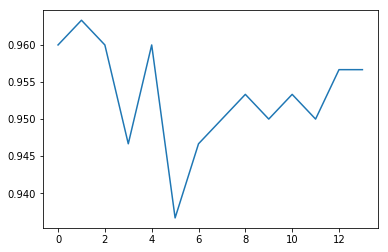

In [95]:
acc=[]
for i in range(len(accuracy)):
    if accuracy[i] > 0:
        acc.append(accuracy[i])

plt.plot(acc)
plt.show()